## Weather Data on NFL games for seasons 2009-2013
##### Matthew Johnson, August 9, 2018

In [71]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

weather = pd.read_csv('/Users/mattjohnson/Desktop/Python2018/NFL/weather_20131231.csv')

In [72]:
abbrev_dict = {"Arizona Cardinals": "ARI", "San Diego Chargers": "SD", "Minnesota Vikings": "MIN",
 "Miami Dolphins": "MIA", "Tennessee Titans": "TEN", "Carolina Panthers": "CAR",
 "New York Giants": "NYG", "Pittsburgh Steelers": "PIT", "Houston Texans": "HOU",
 "Seattle Seahawks": "SEA", "Cleveland Browns": "CLE", "Atlanta Falcons": "ATL",
 "Baltimore Ravens": "BAL", "Green Bay Packers": "GB", "Indianapolis Colts": "IND",
 "New Orleans Saints": "NO", "Cincinnati Bengals": "CIN", "Tampa Bay Buccaneers": "TB",
 "Oakland Raiders": "OAK", "New England Patriots": "NE", "Dallas Cowboys": "DAL",
 "Chicago Bears": "CHI", "Kansas City Chiefs": "KC", "Washington Redskins": "WAS",
 "San Francisco 49ers": "SF", "Buffalo Bills": "BUF", "New York Jets": "NYJ",
 "Philadelphia Eagles": "PHI", "Denver Broncos": "DEN", "Jacksonville Jaguars": "JAX",
 "Detroit Lions": "DET", "St. Louis Rams": "STL"}

In [117]:

def clean_weather_data(df):
    df['Season'] = pd.to_numeric(df['date'].str[-4:])
    df = df[ df['Season'] >= 2009]
    df['date'] = df['date'].str[:-5]
    df['wind_chill'] = df['wind_chill'].fillna(0)
    df['humidity'] = pd.to_numeric(df['humidity'].str[:-1])
    df['humidity'] = df['humidity'].fillna(df['humidity'].mean())
    df['humidity'] = df['humidity'].round(0)
    df['wind_mph'] = pd.to_numeric(df['wind_mph']).fillna(0.0)
    df.drop(['id','weather'], axis=1, inplace=True)
    df['home_team'] = df['home_team'].map(abbrev_dict)
    df['away_team'] = df['away_team'].map(abbrev_dict)
    df.reset_index(drop=True, inplace=True)

    return df

In [118]:
data = clean_weather_data(weather)

In [139]:
homedf = data[['home_team', 'away_team','home_score', 'away_score', 'temperature',
       'wind_chill', 'humidity', 'wind_mph', 'date', 'Season', 'home_team']]
awaydf = data[['away_team', 'home_team', 'away_score', 'home_score', 'temperature',
       'wind_chill', 'humidity', 'wind_mph', 'date', 'Season', 'home_team']]
df_list = [homedf, awaydf]
for df in df_list:
    df.columns = ['offenseTeam', 'defenseTeam','off_score', 'def_score', 'temperature',
       'wind_chill', 'humidity', 'wind_mph', 'date', 'Season', 'home_team']
    
all_data = pd.concat([homedf, awaydf])

tempdf = all_data['date'].str.split('/').apply(pd.Series)
for col in tempdf.columns:
    tempdf[col] =  tempdf[col].astype(str).apply(lambda x: x.zfill(2))
    
all_data['date'] = tempdf[0] + '/' + tempdf[1]
    
all_data['Season'] = all_data['Season'].astype(str)

all_data['mergeCode'] = all_data['Season'] + '-' + all_data['date'] + '-' + all_data['offenseTeam']

In [146]:
all_data.shape

(2238, 12)

In [157]:
vegas_stats = pd.read_csv('/Users/mattjohnson/Desktop/Python2018/NFL/weeks6to16_vegas_and_stats.csv')

vegas_stats.shape

(2018, 58)

In [158]:
merged_data = pd.merge(all_data.reset_index(drop=True), vegas_stats.reset_index(drop=True), 
                    on='mergeCode', how='outer')

In [159]:
merged_data.shape

(3323, 69)

In [160]:
drop_na_df = merged_data.dropna()
drop_na_df.shape

(934, 69)

In [196]:
#X = drop_na_df
drop_na_df = merged_data.dropna()
drops = ['Unnamed: 0', 'off_score', 'def_score', 'gameid', 'QB Kneel_rolling5', 'date_y', 
         'Date', 'Season_x','mergeCode', 'offenseTeam_y', 'Week_y', 'Week_rolling5', 'date_x', 
         'gameid_rolling5', 'Season_y', 'defenseTeam_y', 'offenseTeam_x', 'defenseTeam_x',
        'DEF_QB Kneel_rolling5', 'DEF_gameid_rolling5', 'Week_x']
drop_na_df.drop(drops, axis=1, inplace=True)
#drop_na_df.columns



In [197]:
from scipy.stats import norm, skew

numeric_feats = drop_na_df.dtypes[drop_na_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = drop_na_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(20)


Skew in numerical features: 



,Skew
TwoPointConv_rolling5,21.540709
DEF_FG_50_rolling5,10.039298
FG_50_rolling5,9.051023
FieldGoalBad_rolling5,6.441987
TwoPointConv,5.593929
wind_chill,4.005797
DEF_FG_40_rolling5,1.467105
FG_40_rolling5,1.447323
wind_mph,1.302951
Kicker_Pts,0.478864


In [198]:
skewness = skewness[abs(skewness) > 0.75]

from scipy.special import boxcox1p
skewed_features = skewness.index
skewed_features = skewed_features.drop('Kicker_Pts')

print("There are {} skewed numerical features to Box Cox transform".format(len(skewed_features)))

lam = 0.15
for feat in skewed_features:
    drop_na_df[feat] = boxcox1p(drop_na_df[feat], lam)
    

There are 43 skewed numerical features to Box Cox transform


In [199]:
from sklearn.model_selection import train_test_split
X = drop_na_df.select_dtypes(include=['int64', 'float64']).fillna(0)
Xtrain, Xtest, ytrain, ytest = train_test_split(X.drop('Kicker_Pts', axis=1), X['Kicker_Pts'])

In [200]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 2018)
rf.fit(Xtrain, ytrain);

In [201]:
predictions = rf.predict(Xtest)
errors = abs(predictions - ytest)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 3.02


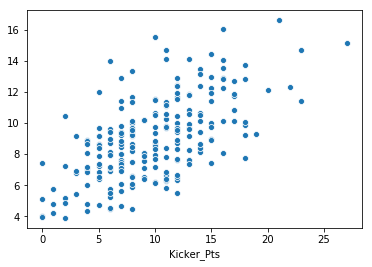

In [202]:
sns.scatterplot(x=ytest, y=predictions)

In [183]:
corrmat = pd.DataFrame(X.corr()['Kicker_Pts'])
corrmat.sort_values('Kicker_Pts', ascending=False)[1:12]

,Kicker_Pts
Kicker_Pts_rolling5,0.445654
DEF_Kicker_Pts_rolling5,0.445184
DEF_FieldGoalGood_rolling5,0.331577
FieldGoalGood_rolling5,0.289653
DEF_PointsScored_rolling5,0.242648
DEF_FG_40_rolling5,0.220711
PointsScored_rolling5,0.213869
FG_30_rolling5,0.196601
FG_40_rolling5,0.193731
DEF_FG_30_rolling5,0.171794


In [156]:
predictions = rf.predict(Xtest)
errors = abs(predictions - ytest)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 3.12
